In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cudf
pd.set_option('display.max_columns', 150)

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import gc
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore") # 忽略警告訊息

In [2]:
import janestreet
env = janestreet.make_env() # initialize the environment
iter_test = env.iter_test() # an iterator which loops over the test set

In [3]:
#def objective(trial):    #SET optuna 
#    import optuna
#    train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.25)
#    dtrain = xgb.DMatrix(train_x, label=train_y)
#    dvalid = xgb.DMatrix(valid_x, label=valid_y)
#   objective_list_reg = ['reg:linear', 'reg:gamma', 'reg:tweedie']
#    metric_list = ['rmse']
#    params ={'boosting':trial.suggest_categorical('boosting', 'gbtree'),
#            'tree_method':trial.suggest_categorical('tree_method', 'gpu_hist'),
#            'max_depth':trial.suggest_int('max_depth', 2, 25),
#            'reg_alpha':trial.suggest_int('reg_alpha', 0, 5),
#            'reg_lambda':trial.suggest_int('reg_lambda', 0, 5),
#            'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
#            'gamma':trial.suggest_int('gamma', 0, 5),
#            'learning_rate':trial.suggest_loguniform('learning_rate',0.005,0.5),
#            'eval_metric':trial.suggest_categorical('eval_metric', metric_list),
#            'objective':trial.suggest_categorical('objective', objective_list_reg),
#            'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree', 0.1, 1, 0.01),
#            'colsample_bynode':trial.suggest_discrete_uniform('colsample_bynode', 0.1, 1, 0.01),
#            'colsample_bylevel':trial.suggest_discrete_uniform('colsample_bylevel', 0.1, 1, 0.01),
#            'subsample':trial.suggest_discrete_uniform('subsample', 0.5, 1, 0.05),
#            'nthread' : -1  
#     }
#
#    bst = xgb.train(param, dtrain)
#    preds = bst.predict(dvalid)
#    pred_labels = np.rint(preds)
#    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
#    return accuracy

In [4]:
def XGB(train_x, train_y):
    import xgboost as xgb
    model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=11,
    min_child_weight=9.15,
    gamma=0.59,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.7,
    alpha=10.4,
    nthread=5,
    missing=-999,
    random_state=2020,
    tree_method='gpu_hist')  # THE MAGICAL PARAMETER)
    model.fit(train_x, train_y)     # 訓練模型
    print("XGBoost version:", xgb.__version__) # just run once
    return model

In [5]:
def Fillnan(X):
    # fillna
    col = {'feature_7': np.product(X['feature_7'].mode()),'feature_8': np.product(X['feature_8'].mode()),'feature_72': np.product(X['feature_72'].mode()),'feature_78': np.product(X['feature_78'].mode())}
    #col = {'feature_7': np.product(X['feature_7'].mode()),'feature_8': np.product(X['feature_8'].mode()),'feature_72': np.product(X['feature_72'].mode()),'feature_78': np.product(X['feature_78'].mode()),'feature_84': np.product(X['feature_84'].mode()),'feature_90': np.product(X['feature_90'].mode()),'feature_96': np.product(X['feature_96'].mode()),'feature_102': np.product(X['feature_102'].mode())}
    #col2 = {'feature_11': np.product(X['feature_11'].mode()),'feature_12': np.product(X['feature_12'].mode()),'feature_13': np.product(X['feature_13'].mode()),'feature_14': np.product(X['feature_14'].mode()),'feature_74': np.product(X['feature_74'].mode()),'feature_75': np.product(X['feature_75'].mode()),'feature_80': np.product(X['feature_80'].mode()),'feature_81': np.product(X['feature_81'].mode()),'feature_86': np.product(X['feature_86'].mode()),'feature_87': np.product(X['feature_87'].mode()),'feature_92': np.product(X['feature_92'].mode()),'feature_93': np.product(X['feature_93'].mode()),'feature_98': np.product(X['feature_98'].mode()),'feature_99': np.product(X['feature_99'].mode()),'feature_104': np.product(X['feature_104'].mode()),'feature_105': np.product(X['feature_105'].mode()),'feature_111': np.product(X['feature_111'].mode()),'feature_117': np.product(X['feature_117'].mode())}
    X.fillna(value=col,inplace=True)
    #X.fillna(value=col2,inplace=True)
    #X.fillna(X.mean(),inplace=True)
    del col
    return X

In [6]:
def Average(X):
    # feature avg
    num = 0
    i = 0
    for feature in X:
        if (i != 7) and (i != 8) and (i != 72) and (i != 78):
        #if (i != 7) and (i != 8) and (i != 72) and (i != 78) and (i != 84) and (i != 90) and (i != 96) and (i != 102):
        #if (i != 7) and (i != 8) and (i != 72) and (i != 78) and (i != 84) and (i != 90) and (i != 96) and (i != 102) and (i != 11) and (i != 12) and (i != 13) and (i != 14) and (i != 74) and (i != 75) and (i != 80) and (i != 81) and (i != 86) and (i != 87) and (i != 92) and (i != 93) and (i != 98) and (i != 99) and (i != 104) and (i != 105) and (i != 111) and (i != 117):
            indx1 = X[feature] > 0
            indx2 = indx1 == False
            train[feature][indx1] =  1
            train[feature][indx2] = -1
            #train[feature] = X[feature].apply(lambda x:1 if x > 0 else -1) # 以X為條件將train[feature]的Data分兩類
            check = train[[feature, 'resp']].groupby([feature], as_index=False).mean().sort_values(by='resp', ascending=False) #1,-1分群
            if check['resp'][0] > check['resp'][1]:
                num += check['resp'][0] - check['resp'][1] # 求出所有feature差和
            else:
                num += check['resp'][1] - check['resp'][0]
            del check
        i+=1
    avg = num/126
    #avg = num/122
    #avg = num/104   
    return avg
    #0.0005615499604115825
    #0.0006161447326094877

In [7]:
def Feature(avg,X):
    val = 0
    i = 0
    needft = []
    for feature in X:
        if (i != 7) and (i != 8) and (i != 72) and (i != 78):
        #if (i != 7) and (i != 8) and (i != 72) and (i != 78) and (i != 84) and (i != 90) and (i != 96) and (i != 102):
        #if (i != 7) and (i != 8) and (i != 72) and (i != 78) and (i != 84) and (i != 90) and (i != 96) and (i != 102) and (i != 11) and (i != 12) and (i != 13) and (i != 14) and (i != 74) and (i != 75) and (i != 80) and (i != 81) and (i != 86) and (i != 87) and (i != 92) and (i != 93) and (i != 98) and (i != 99) and (i != 104) and (i != 105) and (i != 111) and (i != 117):
            indx1 = X[feature] > 0
            indx2 = indx1 == False
            train[feature][indx1] =  1
            train[feature][indx2] = -1
            #train[feature] = X[feature].apply(lambda x:1 if x > 0 else -1) # 以X為條件將train[feature]的Data分兩類
            check = train[[feature, 'resp']].groupby([feature], as_index=False).mean().sort_values(by='resp', ascending=False) # 求兩類平均resp
            if check['resp'][0] > check['resp'][1]: # 大-小
                val = check['resp'][0] - check['resp'][1]
            else:
                val = check['resp'][1] - check['resp'][0]
            if (val - avg) > 0:    # 差 - 平均差
                #X[feature] = X[feature].apply(lambda x:1 if x > 0 else -1)
                needft.append(feature)
            del check,val
        i+=1
    del i
    for feature in needft: # 只做val - avg > 0的data
        indx1 = X[feature] > 0
        indx2 = indx1 == False
        X[feature][indx1] =  1
        X[feature][indx2] = -1
    del indx1,indx2,needft
    return X

In [8]:
%%time
# load Data
train_cudf  = cudf.read_csv('/kaggle/input/jane-street-market-prediction/train.csv')
train = train_cudf.to_pandas()
del train_cudf
features = pd.read_csv('../input/jane-street-market-prediction/features.csv')
example_test = pd.read_csv('../input/jane-street-market-prediction/example_test.csv')
sample_prediction_df = pd.read_csv('../input/jane-street-market-prediction/example_sample_submission.csv')
print ("Data is loaded!")

Data is loaded!
CPU times: user 9.62 s, sys: 5.46 s, total: 15.1 s
Wall time: 1min 40s


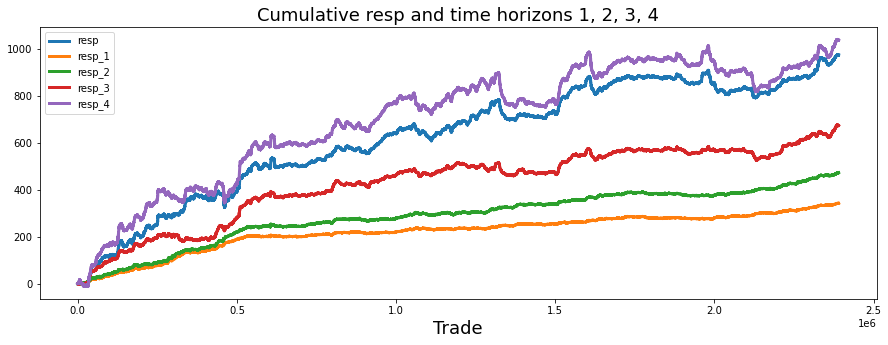

In [9]:
# draw line chart
fig, ax = plt.subplots(figsize=(15, 5))
balance= pd.Series(train['resp']).cumsum()
resp_1= pd.Series(train['resp_1']).cumsum()
resp_2= pd.Series(train['resp_2']).cumsum()
resp_3= pd.Series(train['resp_3']).cumsum()
resp_4= pd.Series(train['resp_4']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_title ("Cumulative resp and time horizons 1, 2, 3, 4", fontsize=18)
balance.plot(lw=3)
resp_1.plot(lw=3)
resp_2.plot(lw=3)
resp_3.plot(lw=3)
resp_4.plot(lw=3)
plt.legend(loc="upper left");
del resp_1
del resp_2
del resp_3
del resp_4
gc.collect();

In [10]:
def DrawHistogram(feature):
    plt.figure(figsize = (12,5))
    ax = sns.distplot(train[feature],
                 bins=3000,
                 kde_kws={"clip":(-5,5)},
                 hist_kws={"range":(-5,5)},
                 color='darkcyan',
                 kde=False);
    values = np.array([rec.get_height() for rec in ax.patches])
    norm = plt.Normalize(values.min(), values.max())
    colors = plt.cm.jet(norm(values))
    for rec, col in zip(ax.patches, colors):
        rec.set_color(col)
    plt.xlabel("Histogram of the resp values", size=14)
    plt.show();
    del values
    gc.collect();

   feature_2      resp
0         -1  0.000429
1          1  0.000150
tag_4
tag is tag_4
7        feature_7
8        feature_8
17      feature_17
18      feature_18
27      feature_27
28      feature_28
55      feature_55
72      feature_72
78      feature_78
84      feature_84
90      feature_90
96      feature_96
102    feature_102
108    feature_108
114    feature_114
120    feature_120
121    feature_121
Name: feature, dtype: object


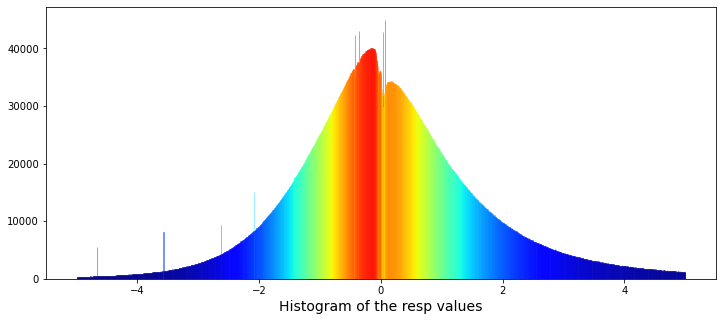

In [11]:
# check
check = train.copy()
check = check.fillna(value={'feature_2': np.product(train['feature_2'].mode())})
check['feature_2'] = check['feature_2'].apply(lambda x:1 if x<-3 else -1)
check = check[['feature_2', 'resp']].groupby(['feature_2'], as_index=False).mean().sort_values(by='resp', ascending=False) #1,-1分群
ck = train['feature_84'].mean()
print(check)

tag = features
new_tag = []
draw = []
for tg in tag:
    if (tag[tg][108] == True) and (tag[tg][114] == True) and (tag[tg][121] == True):
        new_tag.append(tg)
        print(tg)
for tg in new_tag:
    view = tag[tg] == True
    print('tag is ' + tg)
    print(tag['feature'][view])
    draw.append(tag['feature'][view])

for a in draw:
    DrawHistogram(a)

del ck,check,tag,new_tag,draw

In [12]:
# draw missing value 
miss = train.isnull().sum()
px.bar(miss, color=miss.values, title="Total number of missing values for each column").show()
del miss

In [13]:
# missing value%
missing_values_count = train.isnull().sum()
print (missing_values_count)
total_cells = np.product(train.shape)
total_missing = missing_values_count.sum()
m = missing_values_count['feature_9'].sum()
c = np.product(train['feature_9'].shape)
print("features % = ",m/c*100)
print ("% of missing data = ",(total_missing/total_cells) * 100)
del m,c

date              0
weight            0
resp_1            0
resp_2            0
resp_3            0
               ... 
feature_126    8853
feature_127    8853
feature_128    1921
feature_129    1921
ts_id             0
Length: 138, dtype: int64
features % =  0.032963939207468256
% of missing data =  2.050000594444611


In [14]:
# trainX,labelY
target = train['weight'] != 0 # weight==0無參考價值
train = train[target]
train['action'] = (train['resp'].values > 0).astype('int') # >0才進場投資

X = train.loc[:, train.columns.str.contains('feature')]  # 取出有features的
#X = X.drop(['feature_17','feature_18','feature_27','feature_28','feature_84','feature_90','feature_96','feature_102','feature_108','feature_114'],axis=1)
y = train['action']

del target

In [15]:
%%time
X = Fillnan(X)
X.fillna(X.mean(),inplace=True)

CPU times: user 1.57 s, sys: 122 ms, total: 1.69 s
Wall time: 1.71 s


In [16]:
print(X)

         feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
1               -1  -1.349537  -1.704709   0.068058   0.028432   0.193794   
4                1  -3.172026  -3.093182  -0.161518  -0.128149  -0.195006   
6               -1  -3.172026  -3.093182  -0.030588  -0.043175   0.097058   
7               -1   0.446050  -0.466210   0.498751   0.244116   0.412528   
8                1  -3.172026  -3.093182  -0.363836  -0.291496   0.128422   
...            ...        ...        ...        ...        ...        ...   
2390444         -1   1.538675   2.530447   2.494852   3.263345   1.613620   
2390446          1   0.270380  -1.231874  -5.802676  -3.172423  -4.357278   
2390478         -1  -0.134380   0.160580   1.292513   1.453954   0.605912   
2390481         -1  -0.779554  -0.597258   0.674234   0.735692  -0.153732   
2390489         -1  -1.463757  -1.107228  -2.286985  -3.156451  -1.690676   

         feature_6  feature_7  feature_8  feature_9  feature_10  feature_11

In [17]:
%%time
avg = Average(X)
print(avg)

0.0005505603188928621
CPU times: user 9.68 s, sys: 2.08 s, total: 11.8 s
Wall time: 11.5 s


In [18]:
%%time
X = Feature(avg,X) # 1,-1
del train

CPU times: user 11.2 s, sys: 2.14 s, total: 13.4 s
Wall time: 12.9 s


In [19]:
print(X)

         feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
1               -1       -1.0  -1.704709   0.068058   0.028432   0.193794   
4                1       -1.0  -3.093182  -0.161518  -0.128149  -0.195006   
6               -1       -1.0  -3.093182  -0.030588  -0.043175   0.097058   
7               -1        1.0  -0.466210   0.498751   0.244116   0.412528   
8                1       -1.0  -3.093182  -0.363836  -0.291496   0.128422   
...            ...        ...        ...        ...        ...        ...   
2390444         -1        1.0   2.530447   2.494852   3.263345   1.613620   
2390446          1        1.0  -1.231874  -5.802676  -3.172423  -4.357278   
2390478         -1       -1.0   0.160580   1.292513   1.453954   0.605912   
2390481         -1       -1.0  -0.597258   0.674234   0.735692  -0.153732   
2390489         -1       -1.0  -1.107228  -2.286985  -3.156451  -1.690676   

         feature_6  feature_7  feature_8  feature_9  feature_10  feature_11

In [20]:
# optuna
#study = optuna.create_study(direction="maximize")
#study.optimize(objective, n_trials=100)

#print("Number of finished trials: ", len(study.trials))
#print("Best trial:")
#trial = study.best_trial

In [21]:
%%time
model = XGB(X,y)

XGBoost version: 1.2.1
CPU times: user 1min 11s, sys: 3.33 s, total: 1min 14s
Wall time: 1min 15s


In [22]:
for (test_df, prediction_df) in tqdm(iter_test):
    if test_df['weight'].item() > 0: 
        X_test = test_df.loc[:, test_df.columns.str.contains('feature')]
        X_test = Fillnan(X_test)
        #X_test.fillna(-999,inplace=True)
        prediction_df.action = model.predict(X_test)
    else:
        prediction_df.action = 0
    env.predict(prediction_df)